# Machine Learning and Statistics: Data and Models

Material for the [2018 Asterics and Obelics School](https://indico.in2p3.fr/event/16864/).

Content is maintained on [github](https://github.com/Asterics2020-Obelics/School2018/tree/master/mls) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

![sponsor-logos](img/sponsor-logos.png)

This is the standard preamble that these notebooks start with, to establish a consistent environment:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

## Build a model of your data

To get started, let's define some models and generate some data to use in these lectures.

![models1](img/models1.png)

Use a [graphical model](https://en.wikipedia.org/wiki/Graphical_model) to define the relationships between:
 - observed random variables (filled circles)
 - fixed quantities (boxes)
 
[Plate notation](https://en.wikipedia.org/wiki/Plate_notation): dashed box means that features $x$ and $y$ are repeated to give $n$ samples.
 
![graph1](img/graph1.png)

Data consists of $n$ samples with two features: coordinates $(x,y)$ in a 2D space.

Samples have a Gaussian distribution with 5 parameters to represent a single "source" (galaxy, GRB, calorimeter cluster, ...):
 - centroid $(x_0, y_0)$
 - size $\sigma$
 - shape $e_1$, $e_2$
 
![graph1](img/graph1.png)

Start with a **generative model** for this source:

In [3]:
def generate_source(num_samples, centroid, sigma, e1, e2, random_state=None):
    """Generative model for a single source.
        
    Parameters
    ----------
    num_samples : int
        Number of samples to generate.
    centroid : array
        1D array of length 2 containing source centroid (x0, y0), in arbitrary
        spatial units.
    sigma : float
        Gaussian RMS of circular profile before shear is applied, in arbitrary
        spatial units.
    e1 : float
        Shear along the horizontal (e1 > 0) or vertical (e1 < 0) direction.
    e2 : float
        Shear along the +45deg (e2 > 0) or -45deg (e2 < 0) direction.
    random_state : np.random.RandomState or None
        Random state to use for reproducible random numbers.
        
    Returns
    -------
    array
        Array of shape (num_samples, 2) containing the generated (x,y) coordinates.
    """
    random_state = random_state or np.random.RandomState()
    xy = random_state.normal(scale=sigma, size=(num_samples, 2))
    shear = np.array([[1. + e1, e2], [e2, 1. - e1]])
    return np.dot(xy, shear) / (1. - e1 ** 2 - e2 ** 2) + np.asarray(centroid)

Plot some examples of generated sources with the same centroid $(x_0, y_0)$ and size $\sigma$, using a grid in the shear parameters $(e_1, e_2)$ to illustrate how they control the source shape:

In [4]:
def plot_source_grid(nstep=5, n=1000, sigma=2, emax=0.4, xylim=6.5, seed=123):
    gen = np.random.RandomState(seed=seed)
    e_grid = np.linspace(-emax, +emax, nstep)
    centroid = np.zeros(2)
    fig, axes = plt.subplots(nstep, nstep, sharex=True, sharey=True,
                             figsize=(1.8 * nstep, 1.8 * nstep))
    for row, e2 in enumerate(e_grid[::-1]):
        for col, e1 in enumerate(e_grid):
            xy = generate_source(n, centroid, sigma, e1, e2, gen)
            ax = axes[row, col]
            ax.scatter(xy[:, 0], xy[:, 1], s=5, c='r', lw=0, alpha=0.5)
            ax.set_xlim(-xylim * sigma, xylim * sigma)
            ax.set_ylim(-xylim * sigma, xylim * sigma)
            ax.text(0, -xylim * sigma, f'({e1:.1f},{e2:.1f})',
                    horizontalalignment='center', fontsize=14)
            ax.axis('off')
            ax.set_aspect(1)
    plt.subplots_adjust(left=0, right=1, hspace=0.02, wspace=0.02)

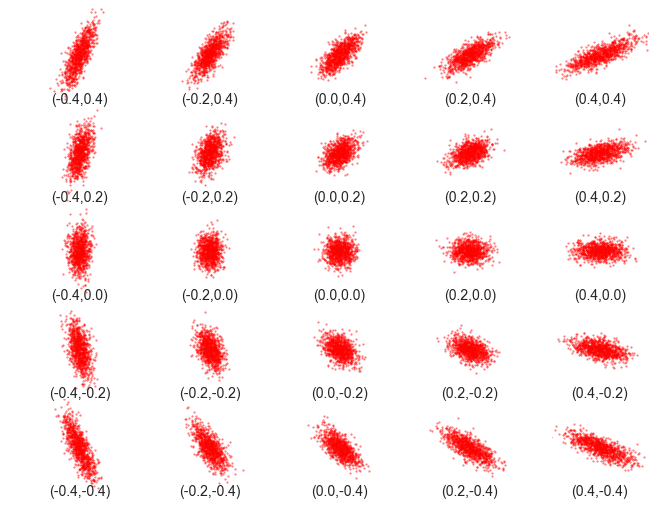

In [5]:
plot_source_grid()

This type of data occurs frequently in astrophysics and (astro)particle physics, for example:
 - visible photons detected from a galaxy.
 - gamma rays detected from an extended source.
 - energy deposits in an electromagnetic calorimeter.
 
The use of shear parameters $(e_1, e_2)$ to measure the source shape is especially relevant to the galaxy example, where systematic distortions of shear (aka "weak lensing") are a key probe of the influence of dark matter between us and the galaxy.

Next, create a **probabilistic model** that evaluates the likelihood of data consisting of $(x,y)$ features given model parameters.

Our model is that data has a [multidimensional Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution:
$$
P(\vec{x}\mid \vec{\mu}, C) =
\left(2\pi\right)^{-d/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$
where here the dimension $d=2$.

This distribution shows up a lot in ML, and we will revisit it several times in other contexts.

A 2D covariance matrix has 3 degrees of freedom that contain the same information as our size ($\sigma$) and shape ($e_1, e_2$) parameters:
$$
C = \left(\frac{\sigma}{1 - e_1^2 - e_2^2}\right)^2 \,
\begin{bmatrix}
1 + 2 e_1 + e^2 & 2 e_2 \\
2 e_2 & 1 - 2 e_1 + e^2
\end{bmatrix}
$$

In [6]:
def covariance(sigma, e1, e2):
    esq = e1 ** 2 + e2 ** 2
    return np.array([
        [1 + 2 * e1 + esq, 2 * e2],
        [2 * e2, 1 - 2 * e1 + esq]
    ]) * (sigma / (1 - esq)) ** 2

The [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) package has useful building blocks for probabilistic models:

In [7]:
import scipy.stats

Each class in `scipy.stats` provides a consistent interface to one probability distribution, with methods to:
 - Evaluate the PDF, log(PDF), CDF or log(CDF).
 - Generate random values from the distribution.
 - Calculate expectation values of moment functions or even arbitrary functions.

We will use the [multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) class, which evaluates the `log` of the probability density for a single $(x,y)$ value,
$$
\log P(x,y\mid x_0, y_0, \sigma, e_1, e_2)
$$

Assuming that the samples $(x_i,y_i)$ are statistically independent, their combined log likelihood is the sum
$$
\sum_i \log P(x_i,y_i\mid x_0, y_0, \sigma, e_1, e_2) \; .
$$

Calculate the log-likelihood of some data given assumed values of the parameters:

In [8]:
def log_source_likelihood(data, centroid, sigma, e1, e2):
    """Probabilistic model for the observed (x,y) of a single source.
    
    Parameters
    ----------
    data : array
        Array of shape (num_samples, 2) of (x,y) coordinates.
    centroid : array
        1D array of length 2 containing source centroid (x0, y0), in arbitrary
        spatial units.
    sigma : float
        Gaussian RMS of circular profile before shear is applied, in arbitrary
        spatial units.
    e1 : float
        Shear along the horizontal (e1 > 0) or vertical (e1 < 0) direction.
    e2 : float
        Shear along the +45deg (e2 > 0) or -45deg (e2 < 0) direction.
        
    Returns
    -------
    float
        Log likelihood of the data given the specified parameter values.
    """
    return scipy.stats.multivariate_normal.logpdf(
        data, mean=centroid, cov=covariance(sigma, e1, e2)).sum()

## Test your models

How can we test a pair of generative and probabilistic models?

1. Generate some data with known parameters.
2. Verify that the log-likelihood is (approximately) maximized at the known parameters. (Why approximately?)

In [9]:
def test_models(num_samples, centroid=[2, -3], sigma=1.5,
                e1_true=0.101, e2_true=-0.202, de_scan=0.25, n_scan=51,
                seed=123, CL=(0.68, 0.95), with_prior=False):
    gen = np.random.RandomState(seed=seed)
    data = generate_source(num_samples, centroid, sigma, e1_true, e2_true, gen)
    de_grid = np.linspace(-de_scan, +de_scan, n_scan)
    loglike = np.empty((n_scan, n_scan))
    logprior = np.empty((n_scan, n_scan))
    for i, de2 in enumerate(de_grid):
        for j, de1 in enumerate(de_grid):
            loglike[i, j] = log_source_likelihood(
                data, centroid, sigma, e1_true + de1, e2_true + de2)
            if with_prior:
                logprior[i, j] = log_prior(
                    [num_samples], [centroid], [sigma],
                    [e1_true + de1], [e2_true + de2])
    fig = plt.figure(figsize=(8, 6))
    dz = logprior if with_prior else loglike
    plt.imshow(dz, interpolation='none', origin='bottom',
               extent=(e1_true - de_scan, e1_true + de_scan,
                       e2_true - de_scan, e2_true + de_scan))
    if with_prior:
        zlabel = 'log prior $P(\Theta)$'
    else:
        zlabel = 'log likelihood $log P(D\mid \Theta)$'
    plt.colorbar().set_label(zlabel, fontsize='large')
    levels = 0.5 * np.sqrt(scipy.stats.chi2.ppf(q=CL, df=2))
    labels = dict(zip(levels, [f'{100*q:.0f}%' for q in CL]))
    cs = plt.contour(e1_true + de_grid, e2_true + de_grid, np.max(loglike) - loglike,
                     colors='k', linestyles='--', levels=levels)
    if not with_prior:
        plt.clabel(cs, cs.levels, inline=True, fmt=labels, fontsize='large')
    if with_prior:
        logpost = logprior + loglike
        dnlp = np.max(logpost) - logpost
        plt.contour(e1_true + de_grid, e2_true + de_grid, dnlp, colors='k',
                    linestyles='-', levels=levels)
    plt.scatter(e1_true, e2_true, marker='x', s=150, c='r')
    dz = logpost if with_prior else loglike
    max_idx = np.argmax(dz.reshape(-1))
    plt.scatter(e1_true + de_grid[max_idx % n_scan], e2_true + de_grid[max_idx // n_scan],
                marker='o', s=100, c='k')
    plt.xlabel('Shear component $e_1$', fontsize='large')
    plt.ylabel('Shear component $e_2$', fontsize='large')

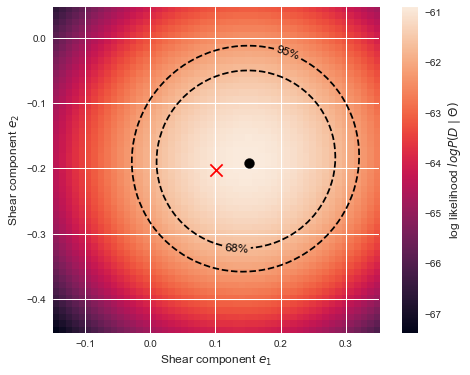

In [10]:
test_models(num_samples=15)

The contours show approximate 2D confidence levels (assuming a Gaussian likelihood) centered on the best parameters $\Theta_0$ using:
$$
P(D\mid \Theta) = P(D\mid\Theta_0) - (0.755, 1.224)
$$
Calculate these magic $n_\sigma$ numbers using:

In [11]:
0.5 * np.sqrt(scipy.stats.chi2.ppf(q=(0.68, 0.95), df=2))

array([0.75479609, 1.22387342])

## Build a model of your parameters

Next, we need models for the parameters which now, in turn, depend on some **hyperparameters**:

![graph2](img/graph2.png)

We are now considering the parameters as unobserved (latent) random variables, so they can be described using probabilities just like the observed data.  (This is the central idea of Bayesian statistics).

Generate a random number of overlapping sources to add one more layer to our models:
- 60% of the time: 1 source
- 25% of the time: 2 sources
- 10% of the time: 3 sources
- 5% of the time: 4 sources

![graph3](img/graph3.png)

In [12]:
np.random.choice((1, 2, 3, 4), size=10, p=(0.5, 0.2, 0.2, 0.1))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Use the following distributions from `scipy.stats` to model our parameters using some hyperparameters:
 - [uniform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html) distribution of centroid ($x_0, y_0$) from a box of size $\Delta_{xy}$.
 - [lognormal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) distributions of size ($\sigma$) and flux ($n$), specified by a mean and mode.
 - [Rayleigh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rayleigh.html) distribution of ellipticity magnitude ($\sqrt{e_1^2 + e_2^2}$) with uniform polar angle.

Convert the mean and mode of a lognormal distribution into corresponding $\mu$ and $\sigma^2$ parameters:

In [13]:
def lognormal_params(mean, mode):
    if mean <= 0 or mode <= 0:
        raise ValueError('Both mean and mode must be positive.')
    return np.log(mean ** 2 * mode) / 3, np.log(mean / mode) * 2 / 3

In [14]:
def generate_parameters(nsrc_probs=[0.6, 0.25, 0.1, 0.05], xy_size=8,
                        flux_mean=4000, flux_mode=3500,
                        sigma_mean=1.3, sigma_mode=1.1, emag_mode=0.15,
                        random_state=None):
    """Sample from the generative model for multiple sources.

    Parameters
    ----------
    nsrc_probs : array
        Array of n probabilities of 1,2,...,n sources.
    xy_size : float
        Centroids will be uniformly distributed on a square centered at
        zero with this width and height (in arbitrary spatial units).
    flux_mean : float
        Mean number of samples per source, used to sample a log-normal
        flux distribution.
    flux_mode : float
        Mode of the log-normal flux distribution.
    sigma_mean : float
        Mean sigma of generated sources (in arbitrary spatial units), used
        to sample a log-normal size distribution.
    sigma_mode : float
        Mode of the log-normal sigma distribution.
    emag_mode : float
        Mode of the shear magnitude, used to sample a Rayleigh distribution.
    random_state : np.random.RandomState or None
        Random state to use for reproducible random numbers.
    
    Returns
    -------
    tuple
        Tuple (num_samples, centroid, size, shear1, shear2) of arrays of
        length num_source containing the generated parameters for each source.
    """
    random_state = random_state or np.random.RandomState()
    
    # Pick the number of sources.
    num_source = 1 + random_state.choice(len(nsrc_probs), p=nsrc_probs)
        
    # Source centroids are drawn from a uniform distribution.
    centroid = random_state.uniform(-0.5 * xy_size, +0.5 * xy_size, size=(num_source, 2))
    
    # Source mean samples are drawn from a log-normal distribution.
    # Note that this distribution is the convolution of the true flux
    # distribution with the shot noise distribution, to keep things simple,
    # so we have to round the flux to the nearest integer.
    flux_mu, flux_var = lognormal_params(flux_mean, flux_mode)
    flux = random_state.lognormal(flux_mu, flux_var ** 0.5, size=num_source)
    num_samples = np.round(flux).astype(int)
    
    # Source sizes are drawn from a log-normal distribution.
    sigma_mu, sigma_var = lognormal_params(sigma_mean, sigma_mode)
    sigma = random_state.lognormal(sigma_mu, sigma_var ** 0.5, size=num_source)
    
    # The shear magnitude is drawn from a Rayleigh distribution.
    assert emag_mode > 0
    emag = random_state.rayleigh(emag_mode, size=num_source)
    
    # The shear rotation is drawn uniformly.
    phi = 2 * np.pi * random_state.uniform(size=num_source)
    e1 = emag * np.cos(phi)
    e2 = emag * np.sin(phi)
        
    return num_samples, centroid, sigma, e1, e2

Build the corresponding probabilistic model for the parameters:

In [15]:
def log_prior(num_samples, centroid, sigma, e1, e2,
              nsrc_probs=[0.6, 0.25, 0.1, 0.05], xy_size=8,
              flux_mean=4000, flux_mode=3500,
              sigma_mean=1.3, sigma_mode=1.1, emag_mode=0.15):
    """Probabilistic model for the unobserved parameters of overlapping sources.
    
    Parameters
    ----------
    num_samples : array
        1D array of length num_source containing the number of samples to generate
        for each source.
    centroid : array
        2D array of shape (num_source, 2) containing the centroid (x0, y0) of
        each source, in arbitrary spatial units.
    sigma : array
        1D array of length num_source containing the size of each source, in arbitrary
        spatial units.
    e1 : array
        1D array of length num_source containing the shear along the horizontal
        (shear1 > 0) or vertical (shear1 < 0) direction for each source.
    e2 : array
        1D array of length num_source containing the shear along the +45deg
        (shear2 > 0) or -45deg (shear2 < 0) direction for each source.
    nsrc_probs : array
        Array of n probabilities of 1,2,...,n sources.
    xy_size : float
        Centroids will be uniformly distributed on a square centered at
        zero with this width and height (in arbitrary spatial units).
    flux_mean : float
        Mean number of samples per source, used to sample a log-normal
        flux distribution.
    flux_mode : float
        Mode of the log-normal flux distribution.
    sigma_mean : float
        Mean sigma of generated sources (in arbitrary spatial units), used
        to sample a log-normal size distribution.
    sigma_mode : float
        Mode of the log-normal sigma distribution.
    emag_mode : float
        Mode of the shear magnitude, used to sample a Rayleigh distribution.
    
    Returns
    -------
    float
        Log of the prior probability density of the parameters given the
        specified hyperparameter values.
    """
    # Probability of observed number of sources.
    num_source = len(num_samples)
    lnprob = np.log(nsrc_probs[num_source - 1])

    # Probability of centroids (which are constant for a uniform distribution).
    lnprob -= num_source * 2 * np.log(xy_size)

    # Probability of number of samples per source (ignoring the effects of
    # rounding to the nearest integer).
    num_samples = np.asarray(num_samples)
    if np.any(num_samples <= 0):
        print('num_samples', num_samples)
        return -np.inf
    flux_mu, flux_var = lognormal_params(flux_mean, flux_mode)
    lnprob += scipy.stats.lognorm.logpdf(
        num_samples, scale=np.exp(flux_mu), s=np.sqrt(flux_var)).sum()
    
    # Probability of Gaussian size.
    sigma = np.asarray(sigma)
    if np.any(sigma <= 0):
        print('sigma', sigma)
        return -np.inf
    sigma_mu, sigma_var = lognormal_params(sigma_mean, sigma_mode)
    lnprob += scipy.stats.lognorm.logpdf(
        sigma, scale=np.exp(sigma_mu), s=np.sqrt(sigma_var)).sum()
    
    # Probability of shear magnitudes given (e1, e2).
    e1 = np.asarray(e1)
    e2 = np.asarray(e2)
    emag = np.sqrt(e1 ** 2 + e2 ** 2)
    if np.any(emag <= 0):
        print('emag', emag)
        return -np.inf
    lnprob += (scipy.stats.rayleigh.logpdf(emag, scale=emag_mode) - np.log(emag)).sum()
    
    # Probability of shear rotations (which are constant).
    lnprob -= num_source * np.log(2 * np.pi)
    
    return lnprob

Compare the generative (red) and probabilistic (blue) models for parameters:

In [16]:
def plot_distributions(
    nsrc_probs=[0.6, 0.25, 0.1, 0.05], xy_size=8, flux_mean=4000, flux_mode=3500,
    sigma_mean=1.3, sigma_mode=1.1, emag_mode=0.15, seed=123, n_gen=1000):
    
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    nsrc_bins = np.linspace(0.5, 4.5, 5)
    ax[0, 0].hist([1.,2.,3.,4.], weights=nsrc_probs, histtype='stepfilled',
                  lw=2, bins=nsrc_bins, density=True)
    ax[0, 0].set_xlabel('Number of sources')
    ax[0, 0].set_xlim(nsrc_bins[0], nsrc_bins[-1])
    ax[0, 0].set_yticks([])
    
    flux = np.linspace(0, 10000, 50)
    flux_mu, flux_var = lognormal_params(flux_mean, flux_mode)
    ax[0, 1].fill_between(flux, scipy.stats.lognorm.pdf(
        flux, scale=np.exp(flux_mu), s=np.sqrt(flux_var)))
    ax[0, 1].axvline(flux_mean, ls='--', c='k')
    ax[0, 1].axvline(flux_mode, ls=':', c='k')
    ax[0, 1].set_xlim(flux[0], flux[-1])
    ax[0, 1].set_ylim(0, None)
    ax[0, 1].set_xlabel('Number of source samples')
    ax[0, 1].set_yticks([])
    
    sigma = np.linspace(0, 3, 50)
    sigma_mu, sigma_var = lognormal_params(sigma_mean, sigma_mode)
    ax[0, 2].fill_between(sigma, scipy.stats.lognorm.pdf(
        sigma, scale=np.exp(sigma_mu), s=np.sqrt(sigma_var)))
    ax[0, 2].axvline(sigma_mean, ls='--', c='k')
    ax[0, 2].axvline(sigma_mode, ls=':', c='k')
    ax[0, 2].set_xlim(sigma[0], sigma[-1])
    ax[0, 2].set_ylim(0, None)
    ax[0, 2].set_xlabel('Source size $\sigma$')
    ax[0, 2].set_yticks([])

    emag = np.linspace(0, 0.75, 50)
    ax[1, 0].fill_between(emag, scipy.stats.rayleigh.pdf(emag, scale=emag_mode))
    ax[1, 0].axvline(emag_mode, ls=':', c='k')
    ax[1, 0].set_xlim(emag[0], emag[-1])
    ax[1, 0].set_ylim(0, None)
    ax[1, 0].set_xlabel('Source ellipticity $|e|$')
    ax[1, 0].set_yticks([])
    
    gen = np.random.RandomState(seed=seed)
    nsrcvec = []
    nsampvec = []
    x0vec, y0vec = [], []
    sigvec = []
    e1vec, e2vec = [], []
    for i in range(n_gen):
        num_samples, centroid, sig, e1, e2 = generate_parameters(
            nsrc_probs, xy_size, flux_mean, flux_mode, sigma_mean, sigma_mode,
            emag_mode, gen)
        nsrcvec.append(len(num_samples))
        nsampvec.append(num_samples)
        x0vec.append(centroid[:, 0])
        y0vec.append(centroid[:, 1])
        sigvec.append(sig)
        e1vec.append(e1)
        e2vec.append(e2)
        
    e1vec = np.concatenate(e1vec)
    e2vec = np.concatenate(e2vec)
    emagvec = np.sqrt(e1vec ** 2 + e2vec ** 2)
        
    ax[0, 0].hist(nsrcvec, bins=nsrc_bins, lw=2, histtype='step',
                  color='r', density=True)
    
    ax[0, 1].hist(np.concatenate(nsampvec), range=(flux[0], flux[-1]),
                  bins=25, density=True, histtype='step', color='r', lw=2)
    
    ax[0, 2].hist(np.concatenate(sigvec), range=(sigma[0], sigma[-1]),
                  bins=25, density=True, histtype='step', color='r', lw=2)
    
    ax[1, 0].hist(emagvec, range=(emag[0], emag[-1]),
                  bins=25, density=True, histtype='step', color='r', lw=2)

    ax[1, 1].scatter(e1vec, e2vec, c='r', s=10, lw=0)
    ax[1, 1].set_xlabel('Shear $e_1$')
    ax[1, 1].set_ylabel('Shear $e_2$')

    ax[1, 2].scatter(np.concatenate(x0vec), np.concatenate(y0vec), c='r', s=10, lw=0)
    ax[1, 2].set_xlabel('Centroid $x_0$')
    ax[1, 2].set_ylabel('Centroid $y_0$')
    ax[1, 2].set_xlim(-0.6 * xy_size, 0.6 * xy_size)
    ax[1, 2].set_ylim(-0.6 * xy_size, 0.6 * xy_size)
    
    plt.tight_layout()

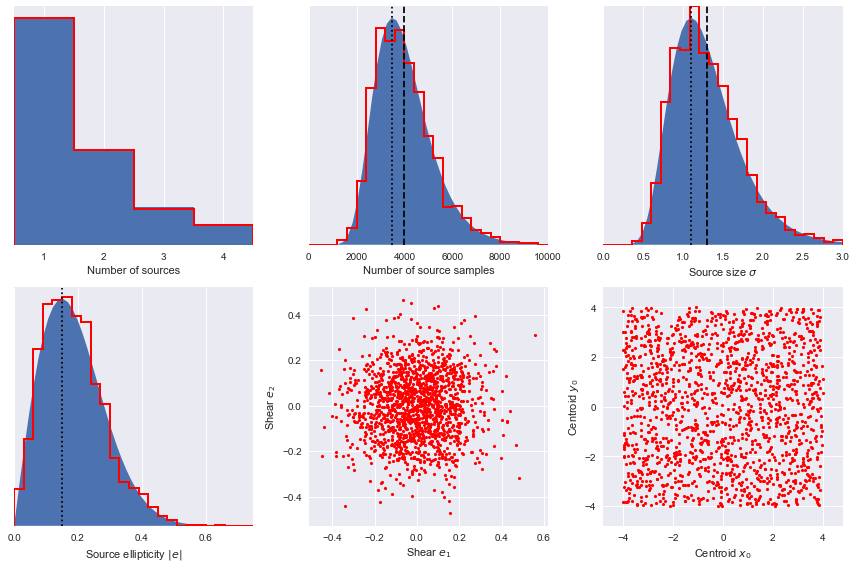

In [17]:
plot_distributions()

## Combine generative models of data and parameters

A **combined generative model** depends on the hyperparameters (like the parameter generator) and:
 - calls the parameter generator once to obtain parameters for 1-4 sources.
 - call the data generator for each source specified by the parameters.

In [18]:
def generate_sources(nsrc_probs=[0.6, 0.25, 0.1, 0.05], xy_size=8,
                     flux_mean=4000, flux_mode=3500, sigma_mean=1.3,
                     sigma_mode=1.1, emag_mode=0.15, random_state=None):
    """Generative model of data and parameters.

    Arguments are identical to generate_parameters().
    
    Returns an array of data for each source and the generated parameters.
    """
    num_samples, centroid, sigma, e1, e2 = generate_parameters(
        nsrc_probs, xy_size, flux_mean, flux_mode, sigma_mean, sigma_mode,
        emag_mode, random_state)
    
    data = []
    for i in range(len(num_samples)):
        data.append(generate_source(
            num_samples[i], centroid[i], sigma[i], e1[i], e2[i], random_state))
        
    return data, num_samples, centroid, sigma, e1, e2

The data we have generated so far is **unbinned**: each sample gives the $(x,y)$ coordinates from some underlying Poisson process (photon counter, etc).

This format captures the maximum information but is inconvenient for algorithms that treat the set of all $(x,y)$ coordinates as a single sample, as we will do soon. The problem is that samples should have a fixed size (number of features) but the number of $(x,y)$ coordinates varies randomly.

The solution is to convert our variable-length unbinned data into fixed-length binned data using, in this case, a 2D histogram (better known in ML as an "image"):

In [19]:
def binned_data(unbinned_data, image_size=16, num_pixels=16):
    # Define image pixel edges in x and y.
    pixel_edges = np.linspace(-0.5 * image_size, +0.5 * image_size, num_pixels + 1)
    # Combine (x,y) coordinates from each source.
    all_sources = np.concatenate(unbinned_data, axis=0)
    # Fill the histogram.
    image, _, _ = np.histogram2d(
        all_sources[:, 0], all_sources[:, 1], (pixel_edges, pixel_edges))
    return image.T

Binned images are convenient for the fixed (small) size, but come with some costs:
 - Loss of information about spatial structure smaller than a pixel.
 - Size tradeoff between points falling outside the image or many empty pixels.

We are now ready to generate a reference dataset to use in other lessons (you can safely ignore any pandas PerformanceWarning).

In [20]:
def generate_dataset(basename='data/sources', num_unbinned=10, num_binned=50000,
                     num_pixels=16, seed=123):
    gen = np.random.RandomState(seed=seed)
    images = np.empty((num_binned, num_pixels * num_pixels), dtype=np.float32)
    params = dict(num_source=[], centroid=[], num_samples=[], sigma=[], e1=[], e2=[])
    for i in range(max(num_unbinned, num_binned)):
        unbinned_data, num_samples, centroid, sigma, e1, e2 = generate_sources(
            random_state=gen)
        image = binned_data(unbinned_data)
        if i < num_unbinned:
            # Shuffle samples from different sources.
            shuffle = gen.permutation(num_samples.sum())
            xy = np.concatenate(unbinned_data, axis=0)[shuffle]
            source_id = np.repeat(np.arange(len(centroid)), num_samples)[shuffle]
            # Save each unbinned realization to a separate file.
            df_xy = pd.DataFrame(xy, columns=('x', 'y'))
            df_xy.to_hdf(f'{basename}_{i}_xy.hf5', 'xy', mode='w')
            df_id = pd.DataFrame(source_id, columns=('k',))
            df_id.to_hdf(f'{basename}_{i}_k.hf5', 'k', mode='w')
        if i < num_binned:
            images[i] = image.flatten()
            params['num_source'].append(len(centroid))
            params['centroid'].append(centroid)
            params['num_samples'].append(num_samples)
            params['sigma'].append(sigma)
            params['e1'].append(e1)
            params['e2'].append(e2)
    df_img = pd.DataFrame(images)
    df_img.to_hdf(f'{basename}_img.hf5', 'img', mode='w')
    df_par = pd.DataFrame(params)
    df_par.to_hdf(f'{basename}_par.hf5', 'par', mode='w')

In [21]:
%time generate_dataset()

CPU times: user 3min 53s, sys: 8.34 s, total: 4min 1s
Wall time: 1min 18s


Verify that the generated data is reproducible on different machines:

In [22]:
!ls -lh data/sources_img.hf5

-rw-r--r--+ 1 david  staff    49M Jun  6 15:42 data/sources_img.hf5


In [23]:
!md5 data/sources_img.hf5

MD5 (data/sources_img.hf5) = fe662e1abbc211cf315a035c99be396a


In [24]:
from mls import plot_image

def plot_sources(nrow=3, ncol=4, xy_size=8):
    assert ncol % 2 == 0
    idx = 0
    df_img = pd.read_hdf('data/sources_img.hf5')
    df_par = pd.read_hdf('data/sources_par.hf5')
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(4 * ncol, 4 * nrow))
    for row in range(nrow):
        for col in range(ncol):
            ax = axes[row, col]
            if col % 2 == 0:
                xy = pd.read_hdf(f'data/sources_{idx}_xy.hf5').values
                labels = pd.read_hdf(f'data/sources_{idx}_k.hf5').values.reshape(-1)
                for k in np.unique(labels):
                    sel = labels == k
                    ax.scatter(xy[sel, 0], xy[sel, 1], lw=0, s=5, alpha=0.5)
                centroid = df_par.iloc[idx]['centroid']
                ax.scatter(centroid[:, 0], centroid[:, 1], c='k', marker='+', s=300, lw=3)
            else:
                plot_image(df_img.iloc[idx].values, ax=ax)
                idx += 1
            ax.set_xlim(-xy_size, +xy_size)
            ax.set_ylim(-xy_size, +xy_size)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(hspace=0.02, wspace=0.02)

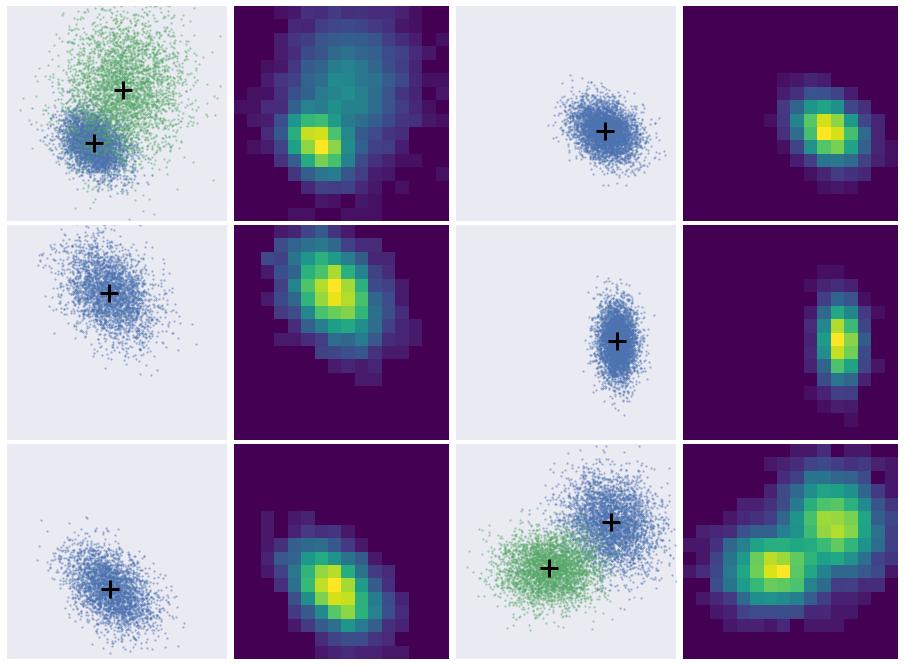

In [25]:
plot_sources()

## Combine probabilistic models of data and parameters

We also need a **combined probabilistic model**. Bayes' rule specifies the how (prior) parameter model and (likelihood) data model should be combined:
$$
P(\Theta\mid D) = \frac{P(D\mid \Theta)\, P(\Theta)}{P(D)}
$$
where the denominator $P(D)$ is called the **evidence** and is just the normalization constant
$$
P(D) \equiv \int P(D\mid \Theta)\, P(\Theta)\, d\Theta \; .
$$
Summarizing the terminology:
 - **likelihood** $P(D\mid\Theta)$: probabilistic model of the data.
 - **prior** $P(\Theta)$: probabilistic model of parameters given prior knowledge.
 - **posterior** $P(\Theta\mid D)$: probabilistic model of parameters combining prior knowledge and new information provided by the data.

With $N$ sources present, the likelihood of the data is represented by a [mixture model](https://en.wikipedia.org/wiki/Mixture_model):
$$
P(D\mid\Theta) = \frac{\sum_{k=1}^N n_k P(D\mid\Theta_k)}{\sum_{k=1}^N n_k} \; ,
$$
where $n_k$ is the assumed number of samples associated with each source $k$ and $P(D\mid\Theta_k)$ is the likelihood of the data assuming only source $k$ is present.

In [26]:
def mixture_likelihood(data, num_samples, centroid, sigma, e1, e2):
    """Calculate likelihood that data is due to a specified mixture of sources
    """
    N = len(num_samples)
    result = 0
    for k in range(N):
        result += num_samples[k] * np.exp(log_source_likelihood(
            data, centroid[k], sigma[k], e1[k], e2[k]))
    return result / num_samples.sum()

The posterior is the fundamental quantity for **inference learning**. A major practical challenge is that the evidence is usually too expensive to calculate, so we usually work with the simpler quantity:
$$
\log P(D\mid \Theta) + \log P(\Theta) = \log P(\Theta\mid D) + \text{constant} \; ,
$$
where the constant is just the log of the evidence. Inference learning techniques such as Markov-Chain Monte Carlo and Variational Inference are specifically designed to work around the problem of not knowing the value of this constant.

In [27]:
def log_posterior(num_samples, centroid, sigma, e1, e2,
                  nsrc_probs=[0.6, 0.25, 0.1, 0.05], xy_size=8,
                  flux_mean=4000, flux_mode=3500,
                  sigma_mean=1.3, sigma_mode=1.1, emag_mode=0.15):
    """Probabilistic model for the combined data and parameters.
    
    The log posterior is evaluated up to an unknown constant (the log evidence).
    """
    return (
        np.log(mixture_likelihood(data, num_samples, centroid, sigma, e1, e2)) +
        log_prior(num_samples, centroid, sigma, e1, e2,
                  nsrc_probs, xy_size, flux_mean, flux_mode,
                  sigma_mean, sigma_mode, emag_mode))

Repeat our earlier scan of the likelihood with respect to $(e_1, e_2)$ for an isolated source ($N=1$):

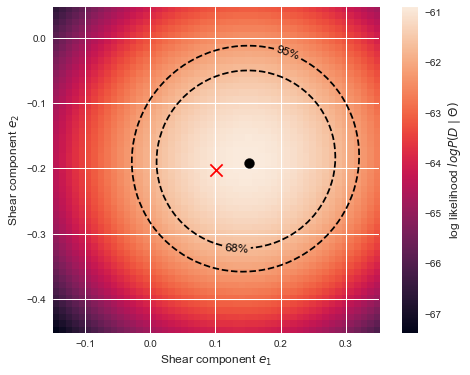

In [28]:
test_models(num_samples=15, with_prior=False)

Now add the prior (shaded background) to calculate the posterior (solid circles).

The prior pulls the posterior closer to the origin, $(e_1=0, e_2=0)$, and also shrinks the uncertainties:

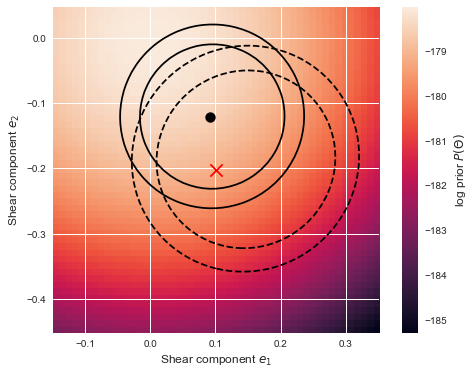

In [29]:
test_models(num_samples=15, with_prior=True)

Some questions to answer using machine learning with these data and models:
- How many sources are present in an image?
- What is the shear magnitude in an image with only one source?
- What is the probability that an image contains exactly one source?

**Exercise:** Classify each question according to the type of learning that is best suited to answer it:
1. inference learning
2. unsupervised learning
3. supervised learning

### Exercise

One of the first tasks when applying machine learning to a problem is to get a baseline:
 - How well does the simplest possible (non-ML) approach work?
 - What is the current "state of the art"?
 - If applicable: what is the "human performance" level?
 
Let's get a "human performance" baseline for the problem: **How many sources are present in an image?**

You are now the machines: I will show you 36 training images, then you must classify 16 test images.

Enter your responses at https://goo.gl/qi2CEV (open this link now).

![scan](img/scan_small.png)

### Acknowledgement:
**H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).**